# Part IV (Optional): Figures and animations

This reuses most of the code from Part III. Except that all KDE and persistent homology computations are repeated but in 2D so that all the visuals are coherent.

2D is much easier to fully illustrate than 3D (what we actually used for our analyses)

This is how most of the TDA-explanatory figures were made, both for the manuscript and for slideshow presentations.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
import os
from scipy import ndimage

from KDEpy import FFTKDE
import json
import persim
import gudhi as gd

import utils
import matplotlib as mpl
from importlib import reload
from skimage import measure

# Load all general data

- Same setup as in the previous notebooks

In [2]:
alphaNmax = 10
alphaNmin = 0.1
Cmap = 'plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
fs = 15

bw = 20
PP = 6
stepsize = 3
nuclei_mask_cutoff = 1
level = 'sub'

sample = 'D2'
wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
nsrc = os.pardir + os.sep + 'nuclear_mask' + os.sep
tsrc = os.pardir + os.sep + 'translocs' + os.sep + sample + os.sep
ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep
gsrc = os.pardir + os.sep + 'geometry' + os.sep + sample + os.sep
isrc = os.pardir + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep

label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv').set_index('gene')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(metatrans.index, dtype=str)

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()

Detected 2937 cells
Detected 1365 nuclei


In [8]:
tidx = 26
foo = metacell.loc[(metacell['nuclei_area'] == 0).values & (transcell.loc[transcriptomes[tidx]] > 500).values].copy()
foo = foo.loc[np.intersect1d(foo.index.values, Cells)]
foo['xratio'] = np.minimum( (foo['length']/foo['height']).values, (foo['height']/foo['length']).values )
foo = foo[foo['xratio'] > 0.925]
print(foo.shape)
reps = foo.index.values
reps = [reps[32]]
foo.sort_values(by=['xratio', 'total_area'], ascending=[False, True]).head()

(34, 20)


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,number_nuclei,total_volume,cyto_volume,nuclei_volume,xratio
ndimage_cellID,,,,,,,,,,,,,,,,,,,,
2219,8410,8819,11834,12245,409,411,69460,0,69460,1.0,8615.34,12021.98,8614.85,12021.64,2221,0,2847860,2847860,0,0.995134
717,11983,12365,5495,5879,382,384,73815,0,73815,1.0,12180.19,5692.93,12179.69,5692.31,718,0,3026415,3026415,0,0.994792
784,12753,13181,5799,6223,428,424,122440,0,122440,1.0,12958.35,6020.55,12957.93,6020.04,785,0,5020040,5020040,0,0.990654
1860,9233,9638,10297,10706,405,409,118705,0,118705,1.0,9437.85,10508.79,9437.39,10508.24,1861,0,4866905,4866905,0,0.990220
493,6394,6780,4486,4866,386,380,84334,0,84334,1.0,6616.72,4694.43,6616.00,4693.70,494,0,3457694,3457694,0,0.984456


In [9]:
SCALE = 16
tidx = 26
coords = translocs[tidx].loc[:, ['X','Y']].values.T
KDE, hcells, hcoords, hextent, hpers, hlt = [ [None for _ in range(len(reps))] for _ in range(6) ]
for i in range(len(KDE)):
    cidx = reps[i]
    
    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc)
    s_ = np.s_[ hextent[i][2]:hextent[i][3] , hextent[i][0]:hextent[i][1] ]
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], label[s_], hextent[i], 0, stepsize, 
                                                                             cell_nuc, maxdims=(hcells[i].shape[1], hcells[i].shape[0]) )
    cmask = label[ coords[1], coords[0] ] == cidx
    hcoords[i] = translocs[tidx].loc[cmask, ['X','Y']].values.T
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i][pxbar] = -1

    cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(KDE[i], level) )
    pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
    hpers[i] = np.zeros((len(pers), 3), dtype=float)
    for k in range(len(hpers[i])):
        hpers[i][k, 0] = pers[k][0]
        hpers[i][k, 1:] = pers[k][1]

    hpers[i] = hpers[i][ np.all(hpers[i] < np.inf, axis=1), :]
    hpers[i] = pd.DataFrame(hpers[i], columns=['H','birth','death']).astype({'H':int})
    
    ld = [ None for _ in range(2) ]
    for k in range(len(ld)):
        ld[k] = np.zeros((len(hpers[i][hpers[i]['H'] == k]), 2))
        ld[k][:,0] = hpers[i].loc[hpers[i]['H'] == k, 'birth']
        ld[k][:,1] = hpers[i].loc[hpers[i]['H'] == k, 'death'] - hpers[i].loc[hpers[i]['H'] == k, 'birth']
    lt_max = np.max([np.max(ld[j]) for j in np.nonzero(list(map(len, ld)))[0] ])
    for k in range(len(ld)):
        ld[k] = ld[k]/lt_max * (SCALE-1)
        bar = ld[k][:,1] >= 1e-2
        ld[k] = ld[k][ bar ]
        
        hpers[i][ hpers[i]['H'] == k ] = hpers[i][ hpers[i]['H'] == k ].loc[bar]
    
    hpers[i].dropna(ignore_index=True, inplace=True)
    hlt[i] = ld

2352	(2, 720)	(6, 3)


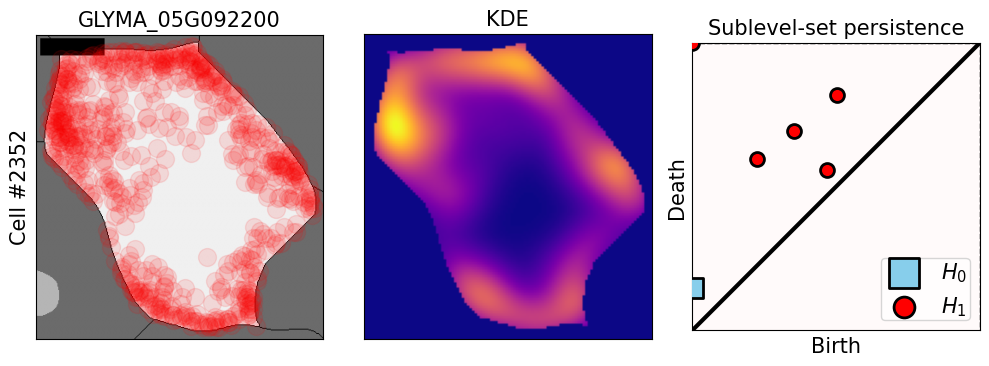

In [10]:
s,S = 15, 100
i = 0

print(reps[i], hcoords[i].shape, hpers[i].shape, sep='\t')
zthr = KDE[i].max() + 1e-7
fig, ax = plt.subplots(1,3,figsize=(10,5))
ax = np.atleast_1d(ax).ravel(); j=0

ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
ax[j].scatter(*hcoords[i][:2], color='r', marker='o', alpha=max([ alphaNmin, min([1, alphaNmax/len(hcoords[i][0])])]), s=int(2e7/hcells[i].size))
ax[j].set_facecolor(wong[2])

j+=1
ax[j].imshow(KDE[i], origin='lower', cmap=Cmap, zorder=1)
ax[j].set_facecolor( mpl.colormaps[Cmap](0) )

j+=1
ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
ax[j].plot([0, zthr, zthr],[zthr, zthr, 0], lw=1, c='k', ls='--', zorder=2)
ax[j].set_xlim(0, zthr); ax[j].set_ylim(0, zthr)

h = hpers[i].loc[ hpers[i]['H'] == 0, ['birth','death']].values.T
h0 = ax[j].scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = hpers[i].loc[ hpers[i]['H'] == 1, ['birth','death']].values.T
h1 = ax[j].scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax[j].set_xlabel('Birth', fontsize=fs)
ax[j].set_ylabel('Death', fontsize=fs)
ax[j].legend([h0,h1],['$H_0$', '$H_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax[j].set_facecolor('snow')

titles = [transcriptomes[tidx], 'KDE', level.title() + 'level-set persistence']
for j in range(len(ax)):
    ax[j].set_title(titles[j], fontsize=fs)
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[j].set_aspect('equal')
ax[0].set_ylabel('Cell #{}'.format(reps[i]), fontsize=fs)

fig.tight_layout()

Individual, label-less plots for each of the panels above.

In [11]:
cidx = reps[i]
kde = KDE[i].copy()
bd = hpers[i].copy()
lt = hlt[i].copy()
X, Y = np.meshgrid(range(kde.shape[1]), range(kde.shape[0]))

In [12]:
# Raw

fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
ax[j].scatter(*hcoords[i][:2], color='b', marker='*', alpha=0.5, s=int(2e7/hcells[i].size), linewidth=1, edgecolor='k')
ax[j].set_facecolor(wong[2])

ax[0].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
fig.tight_layout();

#filename = dst + '{}_c{}_{}level_cell.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)
plt.close()

In [13]:
# KDE

fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(kde, origin='lower', cmap=Cmap, zorder=1)
ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
fig.tight_layout();

#filename = dst + '{}_c{}_{}level_kde.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)
plt.close()

# Plot different stages of the sublevel set filtration

### One per topological feature birth or death

In [14]:
aux = bd.loc[bd['H'] == 0, 'birth'].min()
zthr = np.unique(bd.loc[:, ['birth', 'death']].values)+aux
azim = np.linspace(0, 360, len(zthr), endpoint=False)
argsort = np.argsort(np.argsort(bd.loc[:, ['birth', 'death']].values.ravel())).reshape(len(bd), 2, order='C')
border = [None for _ in range(len(zthr))]
for ii in range(len(border)):
    border[ii] = measure.find_contours(kde, level=zthr[ii])
    for jj in range(len(border[ii])):
        border[ii][jj] = np.flip(border[ii][jj], axis=1)

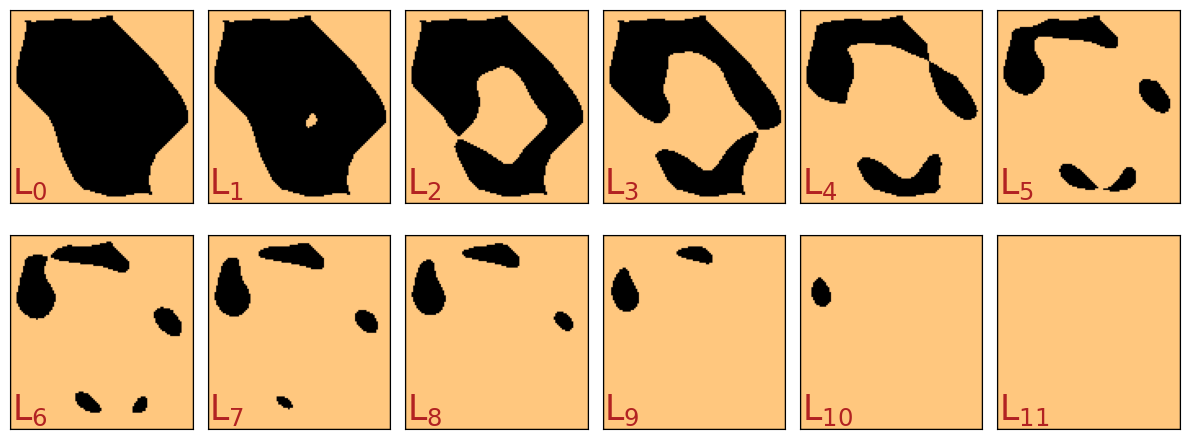

In [15]:
fig, ax = plt.subplots(2, 6, figsize=(12,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j=0

for j in range(min([len(ax), len(zthr)])):
    ax[j].imshow( kde < zthr[j], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1, extent=(0,kde.shape[1],0,kde.shape[0]))
    ax[j].set_xlim(0, kde.shape[1]); ax[j].set_ylim(0, kde.shape[0]);
    ax[j].text(1, 1, 'L$_{{{}}}$'.format(j), ha='left', va='bottom', fontsize=25, c='firebrick', fontname='sans')
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].plot([0,kde.shape[1],kde.shape[1],0,0],[0,0,kde.shape[0],kde.shape[0],0], c='k', lw=1, zorder=3)

fig.tight_layout();

- Now plot each of the panel individually

In [57]:
for j in range(len(zthr)):
    fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel();
    
    ax[0].imshow( kde < zthr[j], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1, extent=(0,kde.shape[1],0,kde.shape[0]))
    ax[0].set_xlim(0, kde.shape[1]); ax[0].set_ylim(0, kde.shape[0]);
    ax[0].text(1, 1, 'L$_{{{}}}$'.format(j), ha='left', va='bottom', fontsize=85, c='firebrick', fontname='sans')
    ax[0].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[0].plot([0,kde.shape[1],kde.shape[1],0,0],[0,0,kde.shape[0],kde.shape[0],0], c='k', lw=5, zorder=3)
    fig.tight_layout();
    
    filename = '{}_c{}_{}level_{:02d}.pdf'.format(transcriptomes[tidx], cidx, level, j)
    print(filename)
    #fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)
    plt.close()

GLYMA_05G092200_c2352_sublevel_00.pdf
GLYMA_05G092200_c2352_sublevel_01.pdf
GLYMA_05G092200_c2352_sublevel_02.pdf
GLYMA_05G092200_c2352_sublevel_03.pdf
GLYMA_05G092200_c2352_sublevel_04.pdf
GLYMA_05G092200_c2352_sublevel_05.pdf
GLYMA_05G092200_c2352_sublevel_06.pdf
GLYMA_05G092200_c2352_sublevel_07.pdf
GLYMA_05G092200_c2352_sublevel_08.pdf
GLYMA_05G092200_c2352_sublevel_09.pdf
GLYMA_05G092200_c2352_sublevel_10.pdf
GLYMA_05G092200_c2352_sublevel_11.pdf


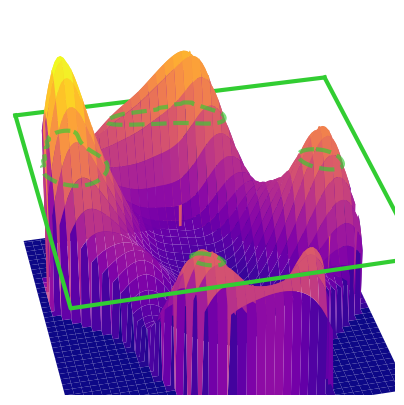

In [40]:
# 3D representation of the KDE
# With a green plane representing the level cut

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,5))
ax.plot_surface(X, Y, kde, cmap=Cmap, alpha=1, zorder=2, vmin=0)

for k,ii in enumerate([7]):
    c = 'limegreen'
    ax.plot([0, kde.shape[1] ], [kde.shape[0], kde.shape[0]], np.repeat(zthr[ii]-aux, 2), 
            c=c, ls='-', lw=3, alpha=1, zorder=1)
    ax.plot([kde.shape[1], kde.shape[1],0,0], [kde.shape[0],1,0,kde.shape[0]], np.repeat(zthr[ii]-aux, 4), 
            c=c, ls='-', lw=3, alpha=1, zorder=3)
    for j in range(len(border[ii])):
        ax.plot(border[ii][j][:,0], border[ii][j][:,1], np.repeat(zthr[ii]-aux, len(border[ii][j])), c=c, ls='--', lw=3, zorder=3, alpha=0.65)

#ax.set_xlim(0, kde.shape[1])
#ax.set_ylim(0, kde.shape[0])
ax.set_zlim(0, zthr[-1])
ax.view_init(elev=35, azim=257, roll=0)
ax.set_box_aspect(aspect=(4,4,3), zoom=1.55)
ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
ax.axis('off');
#filename = dst + '{}_c{}_{}level_3dkde.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)

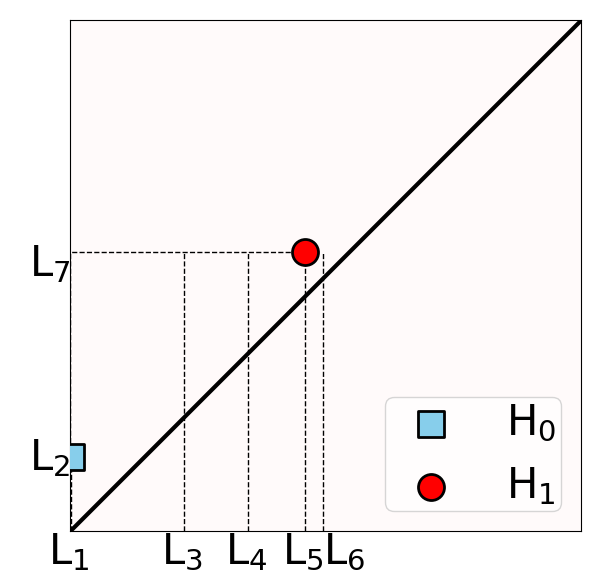

In [61]:
# Persistence Diagram with levels indicated
# Only the relevant features up to time `ii` are shown

S = 350
fs = 30
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j=0

adj = np.zeros(argsort.shape)
adj[4,1] = -1e-6
adj[1,1] = 1e-6
adj[:,0] = -2e-6
adj[3,0] = 0
adj[0,0] = 3

ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)

ii = 7

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=S, zorder=3, label='H$_0$')

h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='H$_1$')

for k in range(len(bd)):
    if bd.iloc[k,1] < zthr[ii] :
        ax[j].plot([bd.iloc[k,1], bd.iloc[k,1]], [0, min([bd.iloc[k,2], zthr[ii]])], lw=1, c='k', ls='--', zorder=2)
        if adj[k,0] < 1:
            ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='k')
    else:
        ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='w', zorder=1)
    if bd.iloc[k,2] < zthr[ii] :
        ax[j].plot([bd.iloc[k,1], 0], [ bd.iloc[k,2], bd.iloc[k,2] ], lw=1, c='k', ls='--', zorder=2)
        if adj[k,1] < 1:
            ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='k')
    else:
        ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='w', zorder=1)

ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax[j].legend([h0,h1],['H$_0$', 'H$_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1)
ax[j].set_facecolor('snow')
ax[j].set_aspect('equal')

fig.tight_layout();

#filename = dst + '{}_c{}_{}level_pd.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0.1)

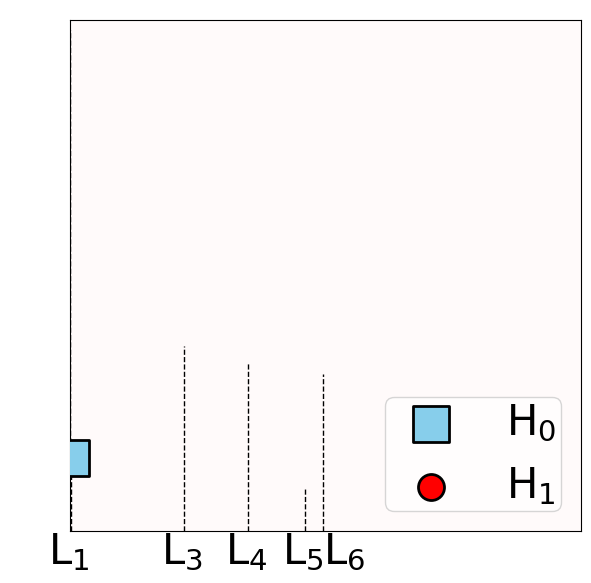

In [49]:
# Lifetime diagram with levels highlighted
# Only the relevant features up to time `ii` are shown

fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j=0

ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='H$_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='H$_1$')

for k in range(len(bd)):
    ax[j].plot([bd.iloc[k,1], bd.iloc[k,1]], [0, bd.iloc[k,2] - bd.iloc[k,1]], lw=1, c='k', ls='--', zorder=2)
    if adj[k,0] < 1:
        ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='k')
    if adj[k,1] < 1:
        ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='w', alpha=0)
        
ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax[j].legend([h0,h1],['H$_0$', 'H$_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1)
ax[j].set_facecolor('snow')
ax[j].set_aspect('equal')

fig.tight_layout();

#filename = dst + '{}_c{}_{}level_lt.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0.1)

# Compute persistence images

In [50]:
sigma = 1
persw = 1
pixsz = 1.5
#pixsz = 0.125 # to use for smooth-looking surfaces
iqr_factor = 1.5

pi_params = {'birth_range':(0, SCALE),
             'pers_range':(0, SCALE),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
pimg = np.asarray(pimgr.transform(lt, skew=False))
pimg_max = np.quantile(pimg[pimg > 0], 0.9999)
print(pimg.shape)

(2, 10, 10)


GLYMA_05G092200_c2352_sublevel_ps0.pdf
GLYMA_05G092200_c2352_sublevel_ps1.pdf


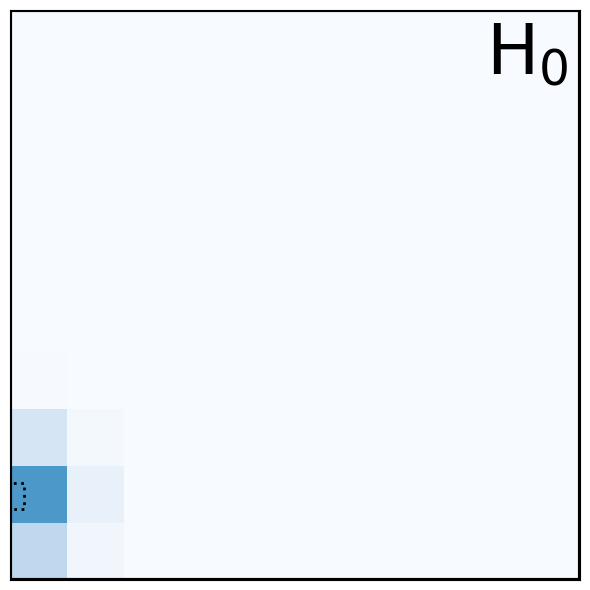

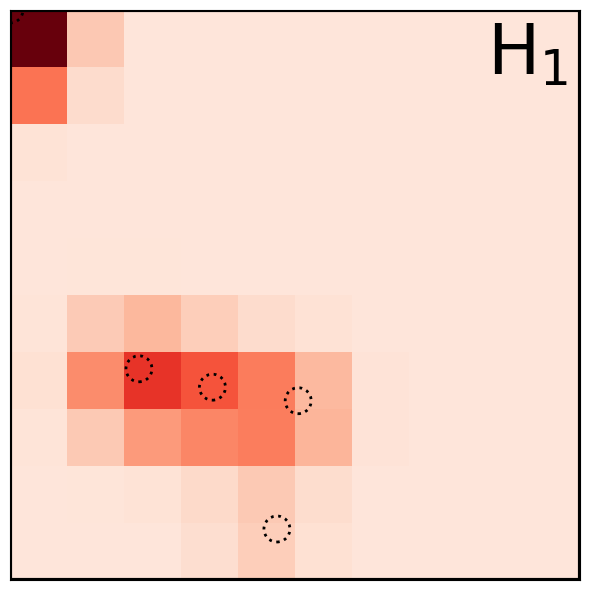

In [54]:
# Persistence image without pixel values written

k = 0
for cmap,marker in zip(['Blues','Reds'],['s','o']):
    fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); j=0
    
    ax[j].imshow(pimg[k].T, origin='lower', cmap=cmap, vmin=-0.1*k*pimg_max, vmax=pimg_max/(4-3*k), extent=(0,len(pimg[k]),0,len(pimg[k])))
    ax[j].set_xlim(0, len(pimg[k])); ax[j].set_ylim(0, len(pimg[k]));
    ax[j].scatter( *((lt[k]/pixsz).T), marker=marker, facecolor='none', edgecolor='k', linewidth=2, s=S, zorder=4, ls=':')
    ax[j].text(.98*pimg[k].shape[1], .98*pimg[k].shape[0],'H$_{{{}}}$'.format(k), ha='right', va='top', fontsize=50, c='k')
    
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].plot([0,len(pimg[k]),len(pimg[k]),0,0],[0,0,len(pimg[k]),len(pimg[k]),0], c='k', lw=3, zorder=3)
    
    fig.tight_layout()
    filename = '{}_c{}_{}level_ps{}.pdf'.format(transcriptomes[tidx], cidx, level,k)
    print(filename)
    #fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0)
    #plt.close()
    k+=1

GLYMA_05G092200_c2352_sublevel_pi0.pdf
GLYMA_05G092200_c2352_sublevel_pi1.pdf


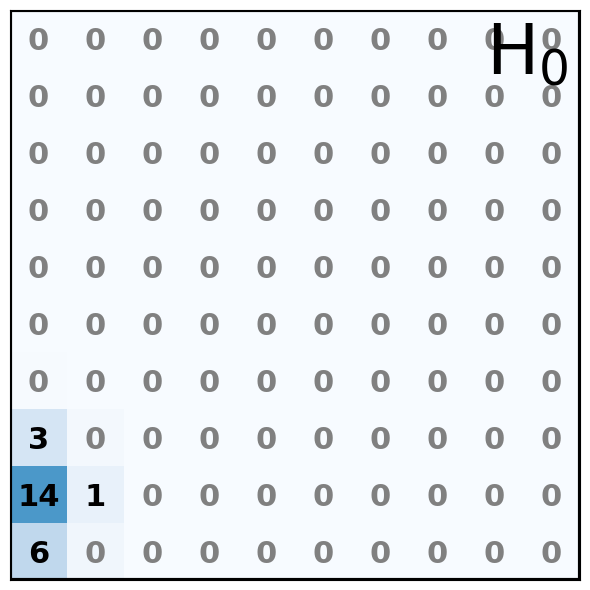

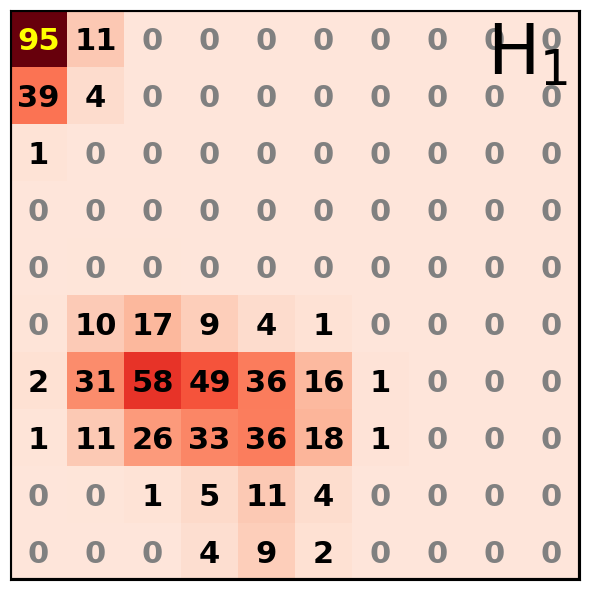

In [53]:
# Persistence image WITH pixel values written

k = 0
s = 22
for cmap,marker in zip(['Blues','Reds'],['s','o']):
    fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); j=0
    
    ax[j].imshow(pimg[k].T, origin='lower', cmap=cmap, vmin=-0.1*k*pimg_max, vmax=pimg_max/(4-3*k), extent=(0,len(pimg[k]),0,len(pimg[k])))
    ax[j].set_xlim(0, len(pimg[k])); ax[j].set_ylim(0, len(pimg[k]));
    
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].plot([0,len(pimg[k]),len(pimg[k]),0,0],[0,0,len(pimg[k]),len(pimg[k]),0], c='k', lw=3, zorder=3)
    for j in range(pimg[k].shape[0]):
        for l in range(pimg[k].shape[1]):
            val = 25*pimg[k,j,l]
            text = '{}'.format(int(val))
            foo = (l < pimg[k].shape[1] - 2) | (j < pimg[k].shape[0]-2) 
            if foo and (val > 1) and (val <= 75):
                ax[0].text(j+.5, l+.5, text, color='k', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
            elif foo and (val > 75):
                ax[0].text(j+.5, l+.5, text, color='yellow', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
            else:
                ax[0].text(j+.5, l+.5, text, color='gray', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
    
    ax[0].text(.98*pimg[k].shape[1], .98*pimg[k].shape[0],'H$_{{{}}}$'.format(k), ha='right', va='top', fontsize=50, c='k', zorder=5)
    
    fig.tight_layout()
    filename = '{}_c{}_{}level_pi{}.pdf'.format(transcriptomes[tidx], cidx, level,k)
    print(filename)
    #fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0)
    #plt.close()
    k+=1

# Panels

In [55]:
adj = np.zeros(argsort.shape)
adj[4,1] = -1e-6
adj[1,1] = 1e-6
adj[:,0] = -2e-6
adj[3,0] = 0
adj[0,0] = 3

In [56]:
ann = ['Persistence Diagram:\n\nAt L$_{{{}}}$\nOne '.format(k) for k in range(len(zthr))]
for k in range(len(ann)):
    b, d = np.asarray(np.nonzero(argsort == k)).squeeze()
    if d == 0:
        ann[k] += 'new '
    
    ann[k] += str(np.where(bd.iloc[b,0], 'hole ', 'blob '))
    if d == 0:
        ann[k] += 'is born'
    else:
        ann[k] += str(np.where(bd.iloc[b,0], 'is sealed.', 'merges.'))
ann[-1] += '\n\nNo more new\ntopological informa-\ntion hereafter.'
ann

['Persistence Diagram:\n\nAt L$_{0}$\nOne new hole is born',
 'Persistence Diagram:\n\nAt L$_{1}$\nOne new blob is born',
 'Persistence Diagram:\n\nAt L$_{2}$\nOne blob merges.',
 'Persistence Diagram:\n\nAt L$_{3}$\nOne new hole is born',
 'Persistence Diagram:\n\nAt L$_{4}$\nOne new hole is born',
 'Persistence Diagram:\n\nAt L$_{5}$\nOne new hole is born',
 'Persistence Diagram:\n\nAt L$_{6}$\nOne new hole is born',
 'Persistence Diagram:\n\nAt L$_{7}$\nOne hole is sealed.',
 'Persistence Diagram:\n\nAt L$_{8}$\nOne hole is sealed.',
 'Persistence Diagram:\n\nAt L$_{9}$\nOne hole is sealed.',
 'Persistence Diagram:\n\nAt L$_{10}$\nOne hole is sealed.',
 'Persistence Diagram:\n\nAt L$_{11}$\nOne hole is sealed.\n\nNo more new\ntopological informa-\ntion hereafter.']

In [59]:
fs = 20
ii = 11
c = 'limegreen'
nrow, ncol = 2,3
for ii in range(len(zthr)):
    fig = plt.figure(figsize=(12,8))
    ax = [ None for _ in range(nrow*ncol)]
    projs = [None for _ in range(len(ax))]
    projs[2] = '3d'
    for j in range(len(ax)):
        ax[j] = fig.add_subplot(nrow, ncol, j+1, projection=projs[j])
    
    j = 0
    ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[j].scatter(*hcoords[i][:2], color='r', marker='*', alpha=0.5, s=int(2e7/hcells[i].size), linewidth=1, edgecolor='k')
    ax[j].set_facecolor(wong[2])
    ax[j].set_title('Molecular Cartography', fontsize=fs)
    
    j = 1
    ax[j].imshow(kde, origin='lower', cmap=Cmap, zorder=1)
    ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
    ax[j].set_title('KDE (Heatmap)', fontsize=fs)
    
    j = 2
    ax[j].plot_surface(X, Y, kde, cmap=Cmap, alpha=1, zorder=2, vmin=0)
    
    ax[j].plot([0, kde.shape[1] ], [kde.shape[0], kde.shape[0]], np.repeat(zthr[ii]-aux, 2), 
            c = c, ls='-', lw=3, alpha=1, zorder=1)
    ax[j].plot([kde.shape[1],kde.shape[1],0,0], [kde.shape[0],1,0,kde.shape[0]], np.repeat(zthr[ii]-aux, 4), 
            c = c, ls='-', lw=3, alpha=1, zorder=3)
    for jj in range(len(border[ii])):
        ax[j].plot(*border[ii][jj].T, np.repeat(zthr[ii]-aux, len(border[ii][jj])), c=c, ls='--', lw=3, zorder=3, alpha=0.65)
    ax[j].set_zlim(0, zthr[-1])
    ax[j].view_init(elev=35, azim=270, roll=0)
    ax[j].set_box_aspect(aspect=(4,4,3), zoom=1.55)
    ax[j].set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax[j].axis('off')
    ax[j].set_title('Sublevel set filtration', fontsize=fs)
    
    j = 3
    ax[j].imshow( kde < zthr[ii], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1)
    ax[j].set_xlabel('Sublevel set', fontsize=fs)
    
    j = 4
    ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
    ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)
    
    h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    h0 = ax[j].scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
    h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    h1 = ax[j].scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
    
    for k in range(len(bd)):
        if bd.iloc[k,1] < zthr[ii] :
            ax[j].plot([bd.iloc[k,1], bd.iloc[k,1]], [0, min([bd.iloc[k,2], zthr[ii]])], lw=1, c='k', ls='--', zorder=2)
            if adj[k,0] < 1:
                ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='k')
        else:
            ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='w', zorder=1)
        if bd.iloc[k,2] < zthr[ii] :
            ax[j].plot([bd.iloc[k,1], 0], [ bd.iloc[k,2], bd.iloc[k,2] ], lw=1, c='k', ls='--', zorder=2)
            if adj[k,1] < 1:
                ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='k')
        else:
            ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='w', zorder=1)
    
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].legend([h0,h1],['Blobs', 'Holes'], loc='lower right', fontsize=fs, borderpad=0, markerscale=1, handletextpad=0)
    ax[j].set_facecolor('snow')
    ax[j].set_xlabel('Birth', fontsize=fs, x=0.8, ha='right')
    ax[j].set_ylabel('Death', fontsize=fs, y=0.35)
    
    for j in [0,1,3]:
        ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
        ax[j].set_aspect('equal')
    
    j = 5
    ax[j].axis('off')
    ax[j].text(0.05, 0.95, ann[ii], ha='left', va='top', fontsize=fs-1)
    
    fig.tight_layout();
    
    filename = transcriptomes[tidx] + '_TDA_c{:05d}_{:02d}.png'.format(cidx, ii)
    print(filename)
    #plt.savefig(filename, format='png', dpi=96, bbox_inches='tight')
    plt.close()

GLYMA_05G092200_TDA_c02352_00.png
GLYMA_05G092200_TDA_c02352_01.png
GLYMA_05G092200_TDA_c02352_02.png
GLYMA_05G092200_TDA_c02352_03.png
GLYMA_05G092200_TDA_c02352_04.png
GLYMA_05G092200_TDA_c02352_05.png
GLYMA_05G092200_TDA_c02352_06.png
GLYMA_05G092200_TDA_c02352_07.png
GLYMA_05G092200_TDA_c02352_08.png
GLYMA_05G092200_TDA_c02352_09.png
GLYMA_05G092200_TDA_c02352_10.png
GLYMA_05G092200_TDA_c02352_11.png


GLYMA_05G092200_TDA_c02352_12.png


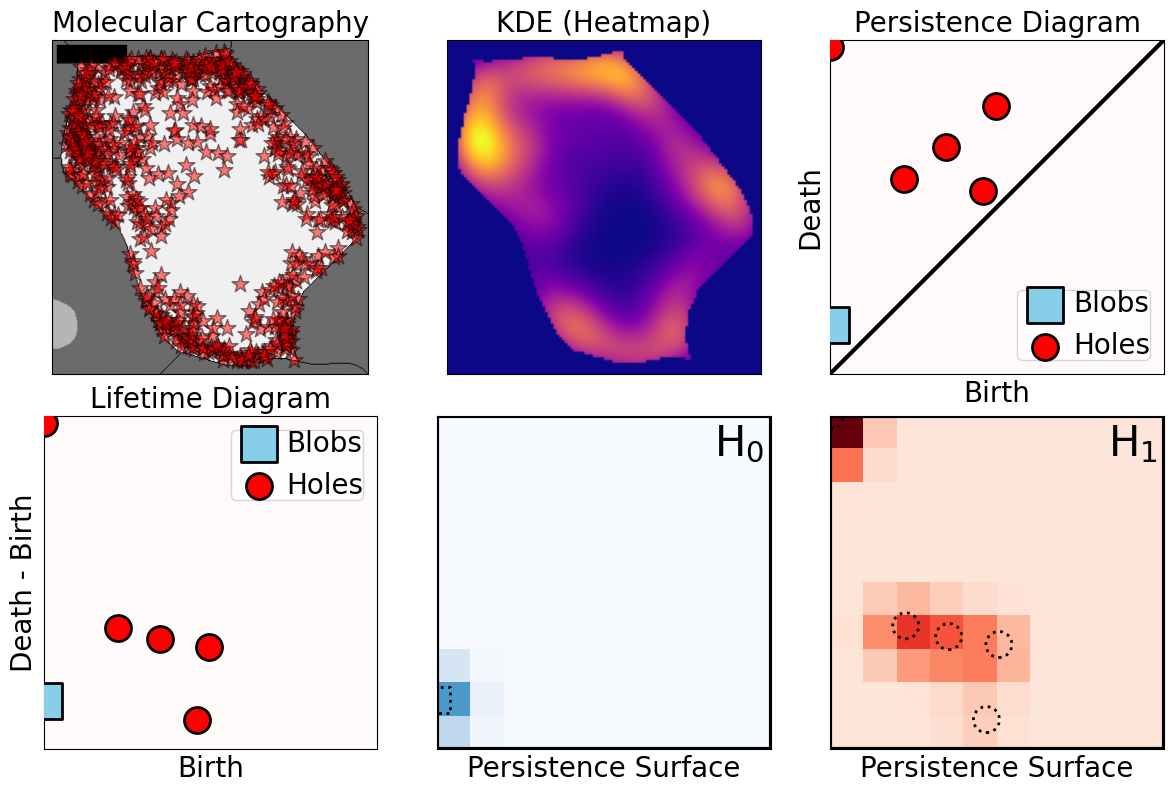

In [64]:
ii = len(zthr)-1
c = 'limegreen'
nrow, ncol = 2,3
fig = plt.figure(figsize=(12,8))
ax = [ None for _ in range(nrow*ncol)]
for j in range(len(ax)):
    ax[j] = fig.add_subplot(nrow, ncol, j+1)

j = 0
ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
ax[j].scatter(*hcoords[i][:2], color='r', marker='*', alpha=0.5, s=int(2e7/hcells[i].size), linewidth=1, edgecolor='k')
ax[j].set_facecolor(wong[2])
ax[j].set_title('Molecular Cartography', fontsize=fs)

j = 1
ax[j].imshow(kde, origin='lower', cmap=Cmap, zorder=1)
ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
ax[j].set_title('KDE (Heatmap)', fontsize=fs)

j = 2
ax[j].set_title('Persistence Diagram', fontsize=fs)
ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)
h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(h[0], h[1], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(h[0], h[1], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
ax[j].legend([h0,h1],['Blobs', 'Holes'], loc='lower right', fontsize=fs, borderpad=0, markerscale=1, handletextpad=0)
ax[j].set_facecolor('snow')
ax[j].set_xlabel('Birth', fontsize=fs)
ax[j].set_ylabel('Death', fontsize=fs)

j = 3
ax[j].set_title('Lifetime Diagram', fontsize=fs)
ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)
h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
ax[j].legend([h0,h1],['Blobs', 'Holes'], loc='upper right', fontsize=fs, borderpad=0, markerscale=1, handletextpad=0)
ax[j].set_facecolor('snow')
ax[j].set_xlabel('Birth', fontsize=fs)
ax[j].set_ylabel('Death - Birth', fontsize=fs)

j,k = 4,0
for cmap,marker in zip(['Blues','Reds'],['s','o']):
    ax[j].imshow(pimg[k].T, origin='lower', cmap=cmap, vmin=-0.1*k*pimg_max, vmax=pimg_max/(4-3*k), extent=(0,len(pimg[k]),0,len(pimg[k])))
    ax[j].set_xlim(0, len(pimg[k])); ax[j].set_ylim(0, len(pimg[k]));
    ax[j].scatter( *((lt[k]/pixsz).T), marker=marker, facecolor='none', edgecolor='k', linewidth=2, s=S, zorder=4, ls=':')
    ax[j].text(.98*pimg[k].shape[1], .98*pimg[k].shape[0],'H$_{{{}}}$'.format(k), ha='right', va='top', fontsize=1.5*fs, c='k')
    ax[j].plot([0,len(pimg[k]),len(pimg[k]),0,0],[0,0,len(pimg[k]),len(pimg[k]),0], c='k', lw=3, zorder=3)
    ax[j].set_xlabel('Persistence Surface', fontsize=fs)
    j += 1 ; k += 1

for j in range(len(ax)):
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].set_aspect('equal')


fig.tight_layout();

filename = transcriptomes[tidx] + '_TDA_c{:05d}_{:02d}.png'.format(cidx, len(zthr))
print(filename)
#plt.savefig(filename, format='png', dpi=96, bbox_inches='tight')

GLYMA_05G092200_TDA_c02352_13.png


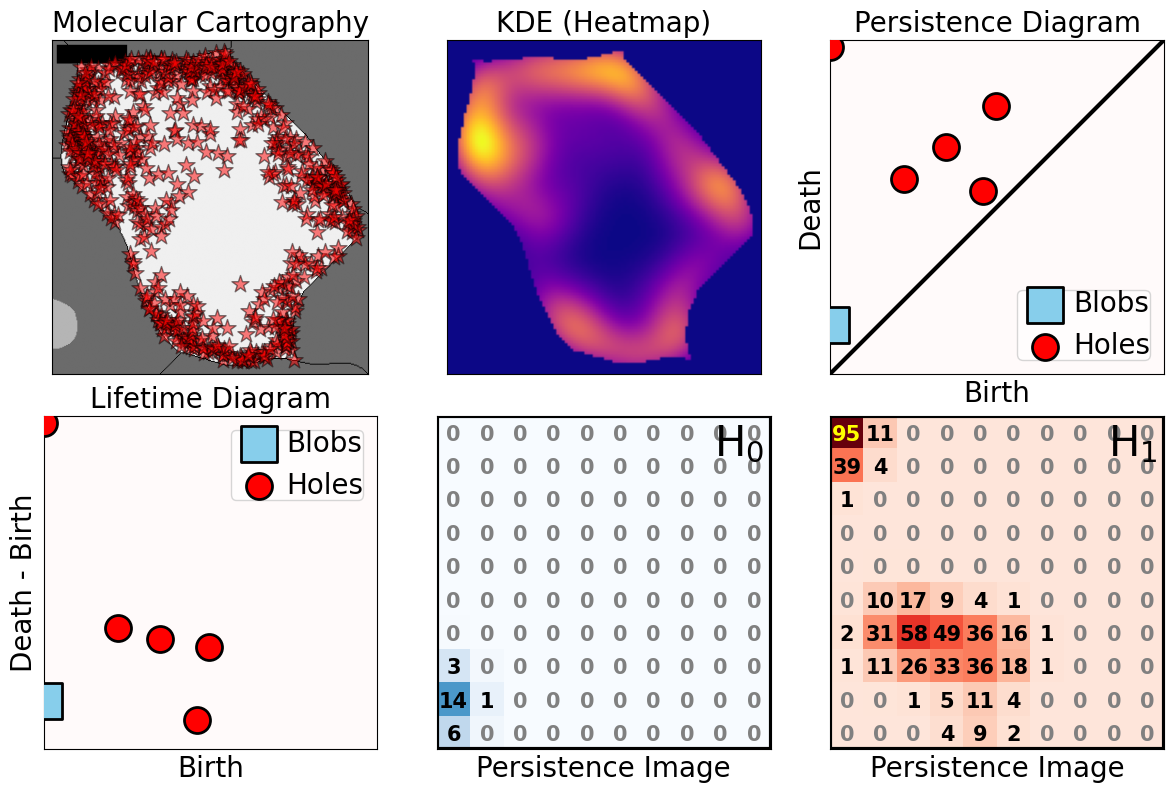

In [67]:
ii = len(zthr)-1
c = 'limegreen'
nrow, ncol = 2,3
fig = plt.figure(figsize=(12,8))
ax = [ None for _ in range(nrow*ncol)]
for j in range(len(ax)):
    ax[j] = fig.add_subplot(nrow, ncol, j+1)

j = 0
ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
ax[j].scatter(*hcoords[i][:2], color='r', marker='*', alpha=0.5, s=int(2e7/hcells[i].size), linewidth=1, edgecolor='k')
ax[j].set_facecolor(wong[2])
ax[j].set_title('Molecular Cartography', fontsize=fs)

j = 1
ax[j].imshow(kde, origin='lower', cmap=Cmap, zorder=1)
ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
ax[j].set_title('KDE (Heatmap)', fontsize=fs)

j = 2
ax[j].set_title('Persistence Diagram', fontsize=fs)
ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)
h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(h[0], h[1], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(h[0], h[1], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
ax[j].legend([h0,h1],['Blobs', 'Holes'], loc='lower right', fontsize=fs, borderpad=0, markerscale=1, handletextpad=0)
ax[j].set_facecolor('snow')
ax[j].set_xlabel('Birth', fontsize=fs)
ax[j].set_ylabel('Death', fontsize=fs)

j = 3
ax[j].set_title('Lifetime Diagram', fontsize=fs)
ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)
h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
ax[j].legend([h0,h1],['Blobs', 'Holes'], loc='upper right', fontsize=fs, borderpad=0, markerscale=1, handletextpad=0)
ax[j].set_facecolor('snow')
ax[j].set_xlabel('Birth', fontsize=fs)
ax[j].set_ylabel('Death - Birth', fontsize=fs)

s = 15
j,k = 4,0
for cmap,marker in zip(['Blues','Reds'],['s','o']):
    ax[j].imshow(pimg[k].T, origin='lower', cmap=cmap, vmin=-0.1*k*pimg_max, vmax=pimg_max/(4-3*k), extent=(0,len(pimg[k]),0,len(pimg[k])))
    ax[j].set_xlim(0, len(pimg[k])); ax[j].set_ylim(0, len(pimg[k]));
    ax[j].plot([0,len(pimg[k]),len(pimg[k]),0,0],[0,0,len(pimg[k]),len(pimg[k]),0], c='k', lw=3, zorder=3)
    for jj in range(pimg[k].shape[0]):
        for l in range(pimg[k].shape[1]):
            val = 25*pimg[k,jj,l]
            text = '{}'.format(int(val))
            foo = (l < pimg[k].shape[1] - 2) | (jj < pimg[k].shape[0]-2) 
            if foo and (val > 1) and (val <= 75):
                ax[j].text(jj+.5, l+.5, text, color='k', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
            elif foo and (val > 75):
                ax[j].text(jj+.5, l+.5, text, color='yellow', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
            else:
                ax[j].text(jj+.5, l+.5, text, color='gray', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
    
    ax[j].text(.98*pimg[k].shape[1], .98*pimg[k].shape[0],'H$_{{{}}}$'.format(k), ha='right', va='top', fontsize=1.5*fs, c='k', zorder=5)
    ax[j].set_xlabel('Persistence Image', fontsize=fs)
    j += 1 ; k += 1

for j in range(len(ax)):
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].set_aspect('equal')


fig.tight_layout();

filename = transcriptomes[tidx] + '_TDA_c{:05d}_{:02d}.png'.format(cidx, len(zthr)+1)
print(filename)
#plt.savefig(filename, format='png', dpi=96, bbox_inches='tight')